# Import packages

In [1]:
import mediapipe as mp
import cv2
import numpy as np
import uuid
import os
import copy
import itertools
from collections import deque, Counter
import csv
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard





# Read labels

In [2]:
actions = ['stop','goLeft', 'goRight', 'modeDiaPo','modeNormal']

# **Build and Train The Gestures Model**

**input shape**

In [3]:
TIME_STEPS = 16
DIMENSION = 2

**Load DataSet and  Features & lables**

In [4]:
dataset = 'Gestures_Presentation_Controle_DataSet/Gesture_Keypoints.csv'
model_save_path = 'Model/Gestures_classifier_MetaData.h5'
Logs = 'C:/oussamaboussaid/Hand_Gestures_Detection_and_Recognition_Project/Logs'

In [5]:
X_features  = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))
Y_lables  = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

# split features ana lables into train and test
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X_features, Y_lables, train_size=0.75, random_state=RANDOM_SEED)

In [6]:
X_train.shape

(576, 32)

**Define a Callback to use for EarlyStopping & TensorBoard**

In [7]:

log_dir = os.path.join('C:/oussamaboussaid/Hand_Gestures_Detection_and_Recognition_Project/Logs')
TB_callback = TensorBoard(log_dir=log_dir)

# callback for earlyStopping
Earlystopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

**launch TensorBoardSession**

In [18]:
%tensorboard -- logdir={log_folder}

UsageError: Line magic function `%tensorboard` not found.


**Build The Model**

In [17]:
# Modl Param
use_lstm = False
NUM_CLASSES = 5

In [18]:
if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [19]:
model.compile( optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

**Train The Model**

In [20]:
model.fit( X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), callbacks=[TB_callback, Earlystopping_callback] )

Epoch 1/1000
5/5 [==============================] - 1s 46ms/step - loss: 1.6037 - accuracy: 0.7552 - val_loss: 1.5860 - val_accuracy: 0.8135
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.5824 - accuracy: 0.8056 - val_loss: 1.5662 - val_accuracy: 0.8549
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.5666 - accuracy: 0.8177 - val_loss: 1.5470 - val_accuracy: 0.8912
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.5484 - accuracy: 0.8212 - val_loss: 1.5281 - val_accuracy: 0.9171
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.5367 - accuracy: 0.8229 - val_loss: 1.5098 - val_accuracy: 0.9171
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.5159 - accuracy: 0.8438 - val_loss: 1.4913 - val_accuracy: 0.9326
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.5054 - accuracy: 0.8299 - val_loss: 1.4730 - val_accuracy: 0.9378
Epoch 8/1000
5

**Model Summary**

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,097
Trainable params: 1,097
Non-trainable params: 0
_________________________________________________________________


**Save Weights**


In [22]:
model.save(model_save_path, include_optimizer=False)

**Test the model ( Make Predictions )**

In [8]:
from keras.models import load_model
model = load_model(model_save_path)

In [9]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))
print(actions[np.argmax(np.squeeze(predict_result))])


1/1 [==============================] - 0s 70ms/step
[5.0478241e-23 1.5258454e-33 1.0000000e+00 2.9786346e-15 7.6859900e-13]
2
goRight


**Evaluate The Model**

Confusion matrix

In [26]:
%pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
Note: you may need to restart the kernel to use updated packages.


7/7 [==============================] - 0s 842us/step


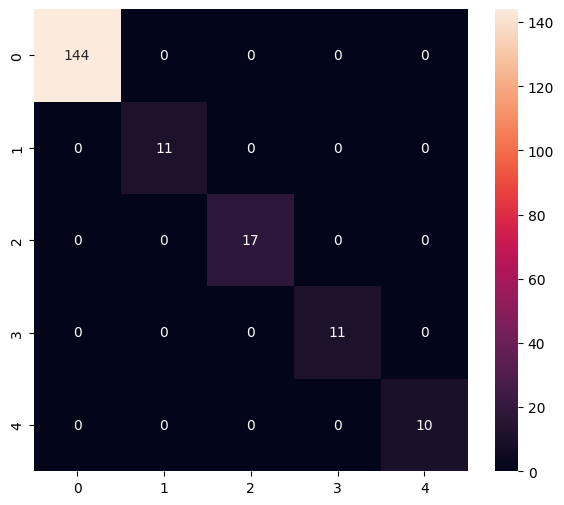

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        10

    accuracy                           1.00       193
   macro avg       1.00      1.00      1.00       193
weighted avg       1.00      1.00      1.00       193



In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [10]:
tflite_save_path = 'Model/Gestures_classifier_MetaData.tflite'

**Transform model (quantization)**

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Kibbou\AppData\Local\Temp\tmppx0bbyvx\assets


6476

**Inference test**

In [12]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [13]:
# get input/output tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [14]:
X_test[0]

array([ 0.        ,  0.        ,  0.        , -0.00208333,  0.0484375 ,
       -0.00416667, -0.3640625 , -0.31041667,  0.28125   ,  0.01041667,
        0.3359375 ,  0.00833333,  0.3921875 ,  0.00625   ,  0.4296875 ,
        0.0125    ,  0.459375  ,  0.01875   ,  0.509375  ,  0.02916667,
        0.525     ,  0.03125   ,  0.5359375 ,  0.03125   ,  0.5359375 ,
        0.02916667,  0.5421875 ,  0.03125   ,  0.546875  ,  0.03333334,
        0.5515625 ,  0.03541667], dtype=float32)

In [15]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [16]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [17]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.0478241e-23 1.5258455e-33 1.0000000e+00 2.9786343e-15 7.6860187e-13]
2


# **Build and Train The Sign Model**

**input shape**

In [2]:
hand = 21
DIMENSION = 2
RANDOM_SEED = 42

In [4]:
dataset_sign = 'Gestures_Presentation_Controle_DataSet/Sign_KeyPoints.csv'
model_save_path_sign = 'Model/Sign_classifier_MetaData.h5'
Logs_sign = 'C:/oussamaboussaid/Hand_Gestures_Detection_and_Recognition_Project/Logs_sign'

In [6]:
X_features_sign = np.loadtxt(dataset_sign, delimiter=',', dtype='float32', usecols=list(range(1, (hand * DIMENSION) + 1)))

y_lables_sign = np.loadtxt(dataset_sign, delimiter=',', dtype='int32', usecols=(0))

X_train, X_test, y_train, y_test = train_test_split(X_features_sign, y_lables_sign, train_size=0.75, random_state=RANDOM_SEED)

In [9]:

log_dir_sign = os.path.join('C:/oussamaboussaid/Hand_Gestures_Detection_and_Recognition_Project/Logs_sign')
TB_callback_sign = TensorBoard(log_dir=log_dir_sign)

# callback for earlyStopping
Earlystopping_callback_sign = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [26]:
%tensorboard -- logdir={log_folder}

UsageError: Line magic function `%tensorboard` not found.


In [16]:
# Modl Param
NUM_CLASSES_sign = 3

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES_sign, activation='softmax')
])

In [18]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,103
Trainable params: 1,103
Non-trainable params: 0
_________________________________________________________________


In [19]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[TB_callback_sign, Earlystopping_callback_sign]
)

Epoch 1/1000
13/13 [==============================] - 1s 17ms/step - loss: 1.0545 - accuracy: 0.3824 - val_loss: 1.0163 - val_accuracy: 0.3701
Epoch 2/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.0296 - accuracy: 0.4485 - val_loss: 0.9978 - val_accuracy: 0.5327
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.0123 - accuracy: 0.4729 - val_loss: 0.9704 - val_accuracy: 0.5477
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.9788 - accuracy: 0.5384 - val_loss: 0.9267 - val_accuracy: 0.6355
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.9484 - accuracy: 0.5727 - val_loss: 0.8636 - val_accuracy: 0.8206
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9156 - accuracy: 0.6132 - val_loss: 0.8011 - val_accuracy: 0.8860
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.8869 - accuracy: 0.6170 - val_loss: 0.7480 - val_accuracy: 0.8860
Epoch

In [21]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9944


In [22]:
model.save(model_save_path_sign, include_optimizer=False)

In [28]:
from keras.models import load_model
model = load_model(model_save_path_sign)

In [24]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 61ms/step
[0.98479456 0.01384558 0.00135998]
0


17/17 [==============================] - 0s 873us/step


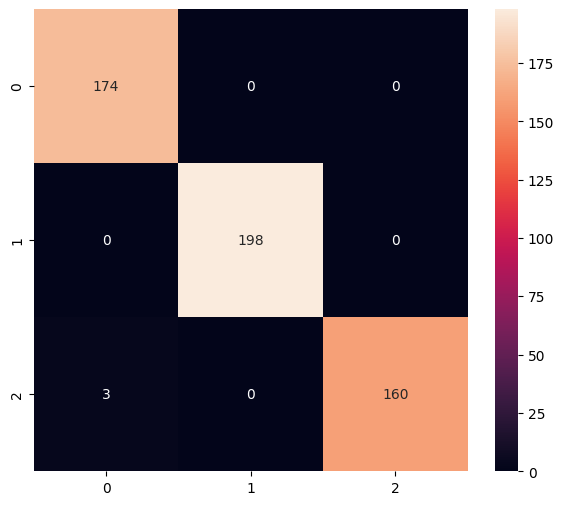

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       174
           1       1.00      1.00      1.00       198
           2       1.00      0.98      0.99       163

    accuracy                           0.99       535
   macro avg       0.99      0.99      0.99       535
weighted avg       0.99      0.99      0.99       535



In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [31]:
# モデルを変換(量子化)
tflite_save_path_sign = 'Model/Sign_classifier_MetaData.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path_sign, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Kibbou\AppData\Local\Temp\tmpbywv3gx6\assets


INFO:tensorflow:Assets written to: C:\Users\Kibbou\AppData\Local\Temp\tmpbywv3gx6\assets


6528

In [33]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path_sign)
interpreter.allocate_tensors()
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [34]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [35]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.98479444 0.01384559 0.00135998]
0
